# "Flow past a cylinder" example

We consider in this example the simulation of incompressible flow past a circular cylinder at $Re=200$.  

The problem to solve is the following, constituted by the dimensionless penalized Vorticty-Transport Equations, also called the **Brinkman Navier-Stokes equations** in velocity ($\boldsymbol u$) -vorticity ($\boldsymbol \omega$) formulation:

$$ \frac{\partial{\boldsymbol \omega (\boldsymbol x, t)}}{\partial{t}} + \boldsymbol u(\boldsymbol x,t).\nabla \boldsymbol \omega(\boldsymbol x,t) - \boldsymbol \omega(\boldsymbol x,t).\nabla \boldsymbol u(\boldsymbol x,t) = \dfrac{1}{Re} \Delta \boldsymbol \omega(\boldsymbol x,t) + \nabla \times \left (\lambda \chi (\boldsymbol u_{cyl}(\boldsymbol x,t) - \boldsymbol u(\boldsymbol x,t)) \right)$$
$$ \Delta \boldsymbol u(\boldsymbol x,t) = -\nabla \times \boldsymbol \omega (\boldsymbol x, t)$$

The first equation is the **momentum equation**:
* $\boldsymbol \omega(\boldsymbol x,t).\nabla \boldsymbol u(\boldsymbol x,t)$ corresponds to the stretching term (which vanishes in 2D)
* $\dfrac{1}{Re} \Delta \boldsymbol \omega(\boldsymbol x,t)$ corresponds to the diffusion term, modelling the diffusion of the vorticity field $\boldsymbol \omega$. $Re$ denotes the Reynolds number.
* $\nabla \times \left (\lambda \chi (\boldsymbol u_{cyl}(\boldsymbol x,t) - \boldsymbol u(\boldsymbol x,t)) \right)$ is the external force term, called the Brinkman penalization term. It allows to model the presence of the cylinder and its action on the flow field. 
    * $\chi$ denotes the characteristic function, equal to 1 inside the cylinder and 0 in the fluid.  
    * The penalization parameter $\lambda$ allows to prescribe the level of permeability of the immersed body ($\lambda$ is precisely inversely proportional to its permeability). Here one considers a solid cylinder (i.e. zero peremability), the $\lambda$ parameter is therefore infinite, and is set in this study to $\lambda=10^8$. 
    * The immersed cylinder is supposed fixed (zero velocity), therefore in this study $\boldsymbol u_{cyl}(\boldsymbol x,t)=0, \ \ \forall \boldsymbol x \in \Omega, \forall t\in \mathbb{R}^+$  
    
The second equation of the above system is the **Poisson equation** allowing to recover the velocity field from the vorticity (it is obtained by combining the incompressibility condition $ \nabla \cdot \boldsymbol u = 0$ and the vorticity definition $\boldsymbol \omega = \nabla \times \boldsymbol u$).

For computational issues, we consider in this example a "false 3D case" in the sense that we consider only few cells in the spanwise direction (=3rd dimension). The domain $\Omega$ is of size $L_x \times L_y \times L_z =[-2.56,2.56] \times [-2.56,2.56] \times [-0.32,0.32]$ with grid resolution $(n_x, n_y, n_z) = (64, 64,8)$ and the cylinder, of diameter $D=1$, is located at $(x,y,z)=(0,0,0)$. The simulation is performed between $t=0$ and $t=2$ with initial and inflow condition:

$$\boldsymbol u_{\infty}(\boldsymbol x,t) = (1,0, 0)$$

Periodic boundary conditions are applied on the domain boundaries, and a vorticity absorption is realized within a sponge zone located at the outlet bewteen $x=4.8$ and $x=5.12$. A velocity correction is applied after vorticity absorption and the above inflow condition is prescribed in order to set a uniform flow at the inlet while ensuring a non-zero circulation.

The no-slip boundary conditions at the cylinder surface are prescribed through the Brinkman penalization term.

$\underline{NB}$ : It is important to note that the mesh resolution is clearly too low, the time step too large and the domain too short in both streamwise and vertical directions to obtain a converged solution. This coarse setup has been chosen for a quick overview of such unsteady problem.

_The execution of the proposed example may take around 15 min (choose the option "Run $\rightarrow$ Run all cells" in the menu)_

## Initialization
### Imports
First import all necessary elements from numpy and hysop

In [1]:
import hysop

/opt/conda/lib/python3.12/site-packages/pyopencl/scan.py:1144: UserWarning: pytools.persistent_dict 'pyopencl-generated-scan-kernel-cache-v1': enabling safe_sync as default. This provides strong protection against data loss, but can be unnecessarily expensive for use cases such as caches.Pass 'safe_sync=False' if occasional data loss is tolerable. Pass 'safe_sync=True' to suppress this warning.
  generic_scan_kernel_cache = WriteOncePersistentDict(


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

pi = np.pi
cos = np.cos
sin = np.sin

In [3]:
from hysop import Box, Simulation, Problem, MPIParams, Field, IOParams
from hysop.defaults import VelocityField, VorticityField, \
    EnstrophyParameter, TimeParameters
from hysop.parameters.tensor_parameter import TensorParameter
from hysop.constants import Implementation, AdvectionCriteria, HYSOP_REAL, \
    StretchingFormulation, StretchingCriteria, Backend
from hysop.operators import Advection, StaticDirectionalStretching, Diffusion, \
    PoissonCurl, AdaptiveTimeStep, HDF_Writer,          \
    Enstrophy, MinMaxFieldStatistics, StrangSplitting,    \
    ParameterPlotter, PenalizeVorticity, FlowRateCorrection, \
    VorticityAbsorption, CustomOperator, DirectionalAdvection, \
    DirectionalStretching
from hysop.numerics.odesolvers.runge_kutta import RK2
from hysop.methods import SpaceDiscretization, Remesh, TimeIntegrator, \
    ComputeGranularity, Interpolation, StrangOrder
from hysop.topology.cartesian_topology import CartesianTopology
from hysop.tools.parameters import CartesianDiscretization

### Domain
Let's define the computational domain and the coefficients/parameters relative to the problem to solve

In [4]:
dim = 3
npts = (8, 128, 128)
box = Box(dim=dim, origin=(-0.16, -2.56, -2.56), length=(0.32, 5.12, 5.12))
print(box)

Box::d0 | 3D rectangular box domain:
  *origin:  [-0.16 -2.56 -2.56]
  *max_pos: [0.16 2.56 2.56]
  *length:  [0.32 5.12 5.12]
  *left  boundary conditions: [PERIODIC(0), PERIODIC(0), PERIODIC(0)]
  *right boundary conditions: [PERIODIC(0), PERIODIC(0), PERIODIC(0)]



In [5]:
cfl = 0.5
lcfl = 0.3
uinf = 1.0
viscosity = 1.0 / 200 # ( = 1 / Re)
outfreq = 50
dt0 = 0.0125

# ====== Cylinder inside the domain ======
RADIUS = 0.5
pos = [0., 0., 0.]

### Fields
Let's define fields and parameters

In [6]:
# Define parameters and field (time, timestep, velocity, vorticity, enstrophy, flowrate)
t, dt = TimeParameters()
velo = VelocityField(domain=box)
vorti = VorticityField(velocity=velo)
cyl = Field(domain=box, name="Cyl", is_vector=False)
wdotw = Field(domain=box, is_vector=False, name="WdotW")
enstrophy = EnstrophyParameter()
flowrate = TensorParameter(name="flowrate", shape=(3, ),
                           initial_value=[0., 0., uinf * box.length[1] * box.length[0]])

In [7]:
# ======= Function to compute flowrate
def computeFlowrate(t, flowrate):
    fr = np.zeros_like(flowrate.value)
    fr[-1] = uinf * box.length[1] * box.length[0]
    # Impose a vertical perturbation in the time interval [Tstart,Tstart+1] to trigger the instability 
    Tstart = 3.0
    if t() >= Tstart and t() <= Tstart + 1.0:
        fr[1] = sin(pi * (t() - Tstart)) * \
                box.length[1] * box.length[0]
    flowrate.value = fr

### Operators
Let's define the different operators involved in the mathematical problem and the numerical parameters (MPI, ...)

In [8]:
# Get default MPI Parameters from domain (even for serial jobs)
mpi_params = MPIParams(comm=box.task_comm,
                       task_id=box.current_task())

# Setup usual implementation specific variables
impl = Implementation.PYTHON
extra_op_kwds = {'mpi_params': mpi_params}
implIsFortran = impl is Implementation.FORTRAN
backend = Backend.HOST
if (impl is Implementation.PYTHON or implIsFortran):
    method = {}
else:
    msg = f'Unknown implementation or change implementation\'{impl}\'.'
    raise ValueError(msg)

In [9]:
# Build the directional operators
# > Directional advection
if implIsFortran:
    advec = Advection(
        implementation=impl,
        name='advec',
        velocity=velo,
        advected_fields=(vorti,),
        variables={velo: npts, vorti: npts},
        dt=dt, **extra_op_kwds)
else:
    advec_dir = DirectionalAdvection(
        implementation=impl,
        name='advec',
        velocity=velo,
        advected_fields=(vorti, ),
        velocity_cfl=0.5,
        variables={velo: npts, vorti: npts},
        dt=dt, **extra_op_kwds)
# > Directional stretching + diffusion
if impl is Implementation.OPENCL:
    StretchOp = DirectionalStretching
else:
    StretchOp = StaticDirectionalStretching
stretch = StretchOp(
    implementation=Implementation.PYTHON if implIsFortran else impl,
    name='stretch',
    formulation=StretchingFormulation.CONSERVATIVE,
    velocity=velo,
    vorticity=vorti,
    variables={velo: npts, vorti: npts},
    dt=dt, **extra_op_kwds)

# > Directional splitting operator subgraph
splitting = StrangSplitting(splitting_dim=dim,
                            order=StrangOrder.STRANG_FIRST_ORDER)
if not implIsFortran:
    splitting.push_operators(advec_dir)
splitting.push_operators(stretch)

Note that the above cell defines the `advec` and `stretch` operators. Here, the advection and stretching equations are solved in a single direction in space. We need to specify how to combine all space directions, as an operator splitting. The particle remeshing is included in each splitting step, directionaly.

In [10]:
# > Penalization operator
penal = PenalizeVorticity(
    implementation=Implementation.PYTHON,
    name='penalization',
    velocity=velo, vorticity=vorti,
    variables={velo: npts, vorti: npts, cyl: npts},
    obstacles=[cyl, ], coeff=1e8,
    dt=dt, **extra_op_kwds)

In [11]:
# > Diffusion operator
diffuse = Diffusion(
    implementation=impl,
    name='diffuse',
    nu=viscosity,
    Fin=vorti,
    variables={vorti: npts},
    dt=dt, **extra_op_kwds)

In [12]:
# > Vorticity absorption operator
absorption = VorticityAbsorption(
    implementation=Implementation.PYTHON,
    velocity=velo, vorticity=vorti,
    start_coord=4.8,
    flowrate=flowrate,
    name="absorption",
    variables={velo: npts, vorti: npts},
    dt=dt, **extra_op_kwds)

In [13]:
# > Poisson operator to recover the velocity from the vorticity
poisson = PoissonCurl(
    implementation=impl,
    name='poisson',
    velocity=velo,
    vorticity=vorti,
    variables={velo: npts, vorti: npts},
    projection=None,
    **extra_op_kwds)

In [14]:
# > Flowrate correction operator to adjust velocity with prescribed flowrate
computeFlowrate = CustomOperator(func=computeFlowrate,
                                 invars=(t, ),
                                 outvars=(flowrate, ))
correctFlowrate = FlowRateCorrection(
    implementation=Implementation.PYTHON,
    name="flowrate_correction",
    velocity=velo, vorticity=vorti,
    flowrate=flowrate,
    dt=dt,
    variables={velo: npts, vorti: npts},
    **extra_op_kwds)

In [15]:
# > Operator to compute the enstrophy
enstrophy_op = Enstrophy(
    name='enstrophy',
    vorticity=vorti, enstrophy=enstrophy, WdotW=wdotw,
    variables={vorti: npts, wdotw: npts},
    implementation=Implementation.PYTHON if implIsFortran else impl, **extra_op_kwds)

In [16]:
# > outputs operator : write 3D velocity and vorticity fields in h5 format every required frequency
io_params = IOParams(filename='fields', frequency=outfreq)
dump_fields = HDF_Writer(name='fields', io_params=io_params,
                         force_backend=backend,
                         variables={velo: npts, vorti: npts}, **extra_op_kwds)

In [17]:
# > Operator to compute the infinite norm of the velocity
min_max_U = MinMaxFieldStatistics(name='min_max_U', field=velo,
                                  Finf=True, implementation=Implementation.PYTHON if implIsFortran else impl, variables={velo: npts},
                                  **extra_op_kwds)
# > Operator to compute the infinite norm of the vorticity
min_max_W = MinMaxFieldStatistics(name='min_max_W', field=vorti,
                                  Finf=True, implementation=Implementation.PYTHON if implIsFortran else impl, variables={vorti: npts},
                                  **extra_op_kwds)

In [18]:
# > Adaptive timestep operator
adapt_dt = AdaptiveTimeStep(dt, equivalent_CFL=True,
                            start_time=10*dt0)  # start adapting timestep at t=10*dt0
dt_cfl = adapt_dt.push_cfl_criteria(cfl=cfl,
                                    Finf=min_max_U.Finf,
                                    equivalent_CFL=True)
dt_advec = adapt_dt.push_advection_criteria(lcfl=lcfl,
                                            Finf=min_max_W.Finf,
                                            criteria=AdvectionCriteria.W_INF)

### Problem
Gather all operators in a single problem to solve.

In [19]:
# Create the problem we want to solve and insert our
# directional splitting subgraph and the standard operators.
# The method dictionnary passed to this graph will be dispatched
# accross all operators contained in the graph.
method = {}
method.update({SpaceDiscretization:   4,
              TimeIntegrator:        RK2,
              Remesh:                Remesh.L4_2,
              Interpolation:         Interpolation.LINEAR})
problem = Problem(method=method)
problem.insert(
    computeFlowrate,
    penal,
    splitting,
    diffuse)
if implIsFortran:
    problem.insert(advec)
problem.insert(
    absorption,
    poisson,
    correctFlowrate,
    enstrophy_op, min_max_U, min_max_W, dump_fields,
    adapt_dt
)

Problem::node3

### Build all lower level stuff
Tell hysop to perform all lover level initialization (allocations, discretization of operators, numerical methods setup, ...)

In [20]:
problem.build()

<string>:11: RuntimeWarning: invalid value encountered in cast


### Setup time discretization
Enforce a time stepping from the prescribed CFL and the velocity field.

In [21]:
# Create a simulation
# (do not forget to specify the t and dt parameters here)
simu = Simulation(start=0.0, end=2.0,
                  max_iter=500,
                  dt0=0.0125,
                  t=t, dt=dt)
simu.write_parameters(t, dt_cfl, dt_advec, dt, enstrophy, flowrate,
                      min_max_U.Finf, min_max_W.Finf, adapt_dt.equivalent_CFL,
                      filename='parameters.txt', precision=8)

### Initial conditions
Setup the initial conditions for this example in velocity, vorticity and cylinder definition.

In [22]:
# ======= Function to compute the cylinder field  =======
def computeCylinder(data, coords, component):
    assert (component == 0)
    (x, y, z) = coords
    dx = x[0, 0, 1] - x[0, 0, 0]
    dy = y[0, 1, 0] - y[0, 0, 0]
    dz = z[1, 0, 0] - z[0, 0, 0]
    data[...] = 0.
    def chi(x, y, z): return np.sqrt((x-pos[0])*(x-pos[0])+(y-pos[1])*(y-pos[1])+(z-z)) <= RADIUS
    data[chi(x, y, z)] = 1.

# ======= Function to compute initial velocity  =======
def computeVel(data, coords, component):
    data[...] = uinf if (component == 0) else 0.0

# ======= Function to compute initial vorticity =======
def computeVort(data, coords, component):
    data[...] = 0.0

problem.initialize_field(cyl, formula=computeCylinder)
problem.initialize_field(velo, formula=computeVel)
problem.initialize_field(vorti, formula=computeVort)

## Solving the problem
Perform the time steps computations, i.e. repeat the operators listed in `problem` through the time steps.

In [23]:
# Finally solve the problem
problem.solve(simu)

## Post-process the solution
Here we aim at ploting the snapshots of velocity or vorticity magnitude in the $XY$ plane at different times and at tracing the enstrophy evolution until $t_{end}=2$:

In [24]:
import h5py

In [25]:
def extract_field(file, resols, lengths, origins, field_to_plot): 
    '''
    file : complete name of the file to read
    resols : array containing grid resolution in each direction (z,y,x)
    lengths : array containing the domain length in each direction (z,y,x)
    origins : array containing the domain origin in each direction (z,y,x)
    field_to_plot : choose between 'Velocity' or 'Vorticity'
    '''
    
    nx, ny, nz = resols[2], resols[1], resols[0]
    Lx, Ly, Lz = lengths[2], lengths[1], lengths[0]
    Ox, Oy, Oz = origins[2], origins[1], origins[0]
    X, Y, Z = np.arange(nx) * (Lx / nx) + Ox, \
              np.arange(ny) * (Ly / ny) + Oy, \
              np.arange(nz) * (Lz / nz) + Oz
        
    x0 = np.where(X==0)[0]
    y0 = np.where(Y==0)[0]
    z0 = np.where(Z==0)[0]
    with h5py.File(file, 'r') as f:
        if field_to_plot=='Vorticity' :
            ux = np.array(f['W0_t1'])[:,:,:]
            uy = np.array(f['W1_t1'])[:,:,:]
            uz = np.array(f['W2_t1'])[:,:,:]
        # otherwise, consider the velocity field
        elif field_to_plot=='Velocity' : 
            ux = np.array(f['UX_t1'])[:,:,:]
            uy = np.array(f['UY_t1'])[:,:,:]
            uz = np.array(f['UZ_t1'])[:,:,:]
        else :
            msg = f'Non available field'
            raise ValueError(msg)
    Umxy = np.squeeze(np.sqrt(ux[z0, :, :] ** 2 + uy[z0, :, :] ** 2 + uz[z0, :, :] ** 2))
    Umxz = np.squeeze(np.sqrt(ux[:, y0, :] ** 2 + uy[:, y0, :] ** 2 + uz[:, y0, :] ** 2))
    return X, Y, Umxy, Umxz

def plot_field(x, y, u):
    plt.pcolormesh(x, y, u, vmin=0., vmax=1.4, cmap='GnBu', shading='gouraud')
    plt.contour(x, y, u, levels=np.linspace(0., 1.4, 20), linewidths=0.75, colors='k')
    plt.gca().add_artist(plt.Circle((0.,0.), 0.5, fill=False, color='r', ls='-', lw=2))

In [26]:
resols = [8, 128, 128]
lengths = [0.32, 5.12, 5.12]
origins = [-0.16, -2.56, -2.56]
files=['interactive/fields_000000.h5', 
       'interactive/fields_000050.h5', 
       'interactive/fields_000100.h5',
       'interactive/fields_000150.h5']
field_to_plot = 'Vorticity' # possibility to change with 'Velocity'

X,Y,Umxy1,Umxz1 = extract_field(files[0], resols, lengths, origins, field_to_plot)
X,Y,Umxy2,Umxz2 = extract_field(files[1], resols, lengths, origins, field_to_plot)
X,Y,Umxy3,Umxz3 = extract_field(files[2], resols, lengths, origins, field_to_plot)
X,Y,Umxy4,Umxz4 = extract_field(files[3], resols, lengths, origins, field_to_plot)

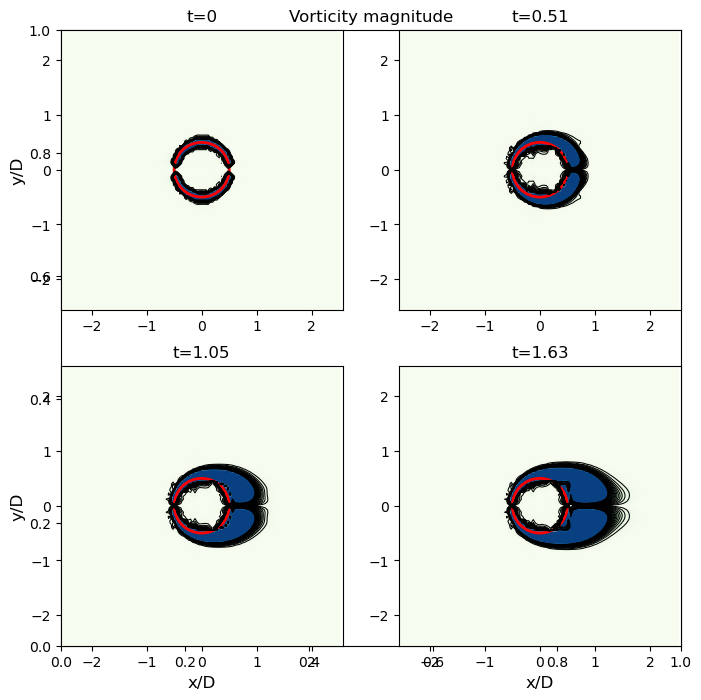

In [27]:
fig=plt.figure(figsize=(8,8))
plt.title(str(field_to_plot)+' magnitude',fontsize=12)
fig.add_subplot(221)

plot_field(X,Y,Umxy1)
plt.xlim(origins[2], lengths[2] + origins[2])
plt.ylim(origins[1], lengths[1] + origins[1])
plt.ylabel('y/D',fontsize=12)
plt.title('t=0',fontsize=12)

fig.add_subplot(222)
plot_field(X,Y,Umxy2)
plt.xlim(origins[2], lengths[2] + origins[2])
plt.ylim(origins[1], lengths[1] + origins[1])
plt.title('t=0.51',fontsize=12)

fig.add_subplot(223)
plot_field(X,Y,Umxy3)
plt.xlim(origins[2], lengths[2] + origins[2])
plt.ylim(origins[1], lengths[1] + origins[1])
plt.xlabel('x/D',fontsize=12)
plt.ylabel('y/D',fontsize=12)
plt.title('t=1.05',fontsize=12)

fig.add_subplot(224)
plot_field(X,Y,Umxy4)
plt.xlim(origins[2], lengths[2] + origins[2])
plt.ylim(origins[1], lengths[1] + origins[1])
plt.xlabel('x/D',fontsize=12)
plt.title('t=1.63',fontsize=12)

plt.show()

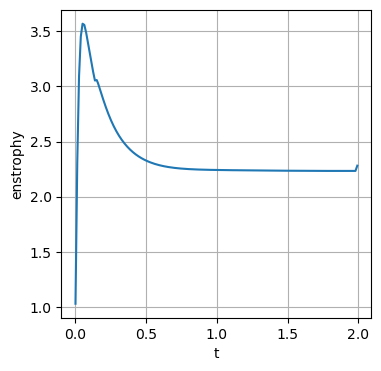

In [28]:
data = np.loadtxt('interactive/parameters.txt', skiprows=2)
t = data[:,0]
enstrophy = data[:,4]

fig=plt.figure(figsize=(4,4))
plt.plot(t,enstrophy)
plt.xlabel('t',fontsize=10)
plt.ylabel('enstrophy',fontsize=10)
plt.grid(True)

## Clean up memory

In [ ]:
# Finalize
problem.finalize()